In [1]:
%load_ext lab_black

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import brier_score_loss, roc_auc_score

In [50]:
import lightgbm as lgb

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from weight_of_evidence import weight_of_evidence

In [7]:
import importlib

importlib.reload(weight_of_evidence)

<module 'weight_of_evidence.weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence/weight_of_evidence.py'>

In [61]:
class NumCatEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes string/object --> numeric categories

    Methods
    -------
        fit
            finds preprocessing strategies for all cols
        transform
            preprocesses all  cols
        fit_transform
            fit & transform
    """

    def fit(self, X, y=None):
        """
        Parameters
        ----------
            X : dataframe
                data to be encoded
        Returns
        ------
            self : BaseEstimator
                fitted transformer
        """
        self.categorical_cols_ = X.select_dtypes(include=["object"]).columns

        self.label_encoder = {}
        for cat_col in self.categorical_cols_:
            values = X[cat_col].astype("str").unique()
            mapping = dict(zip(values, range(len(values))))
            self.label_encoder[cat_col] = mapping

        return self

    def transform(self, X, y=None):
        """
        Parameters
        -----------
            X : dataframe
                data to be encoded
        Returns
        -------
            X : dataframe
                encoded data
        """
        _X = X.copy()
        for cat_col in self.categorical_cols_:
            _X[cat_col] = X[cat_col].astype("str").map(self.label_encoder[cat_col])

        return _X

In [116]:
class LightGBMCategoricalFeatureWrapper:
    def __init__(self, params={}):
        self.params = params
        self.encoder = NumCatEncoder()

    def fit(self, X, y):
        X_encoded = self.encoder.fit_transform(X)
        cat_col_idxs = [i for i, d_type in enumerate(X.dtypes) if d_type == "object"]

        lgb_train = lgb.Dataset(
            data=X_encoded, label=y, categorical_feature=cat_col_idxs
        )

        self.lgb_classifier = lgb.train(params=self.params, train_set=lgb_train)
        return self

    def predict_proba(self, X):
        X_encoded = self.encoder.transform(X)
        p_1 = self.lgb_classifier.predict(X_encoded)
        p_0 = 1.0 - p_1
        return np.stack([p_0, p_1]).T

In [80]:
data = pd.read_csv("~/Downloads/application_train.csv")

In [81]:
EXCLUDE_COLS = [
    "SK_ID_CURR",
    "TARGET",
    "CODE_GENDER",
    "ORGANIZATION_TYPE",
    "NAME_FAMILY_STATUS",
]

In [82]:
CATERORICAL_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("O").columns

In [83]:
NUMERIC_COLS = data.drop(columns=EXCLUDE_COLS).select_dtypes("int64").columns

In [84]:
data[CATERORICAL_COLS] = data[CATERORICAL_COLS].fillna("MISSING")

In [85]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [86]:
ohe_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATERORICAL_COLS),
    ]
)

In [87]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=1e6)

In [88]:
ohe_logit = Pipeline(
    steps=[("preprocessor", ohe_preprocessor), ("log_reg_classifier", log_reg),]
)

In [89]:
ohe_lgb = Pipeline(
    steps=[("preprocessor", ohe_preprocessor), ("lgb_classifier", lgb.LGBMClassifier())]
)

In [122]:
lgb_baseline = LightGBMCategoricalFeatureWrapper()

In [117]:
combined_results = pd.DataFrame()

In [118]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

In [119]:
X = data.drop(columns=EXCLUDE_COLS)
y = data.TARGET

In [120]:
def get_cv_results(X, y, cv, clf, model_name):
    results = {"auc": [], "fold": []}
    fold = 1
    for train, test in cv.split(X, y):
        print(f"fold {fold}")
        prediction = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        try:
            auc = roc_auc_score(y_true=y.iloc[test], y_score=prediction[:, 1])
        except:
            from IPython import embed

            embed()
        results["auc"].append(auc)
        results["fold"].append(fold)
        print(f"auc {auc}")
        fold += 1
    results_df = pd.DataFrame(results)
    results_df["model"] = model_name
    return results_df

In [121]:
combined_results = get_cv_results(X, y, cv, ohe_logit, "ohe logit")

fold 1
auc 0.660356832255731
fold 2
auc 0.6631419031153942
fold 3
auc 0.6540158169998416
fold 4
auc 0.6600730788975613
fold 5
auc 0.6668053062809923


In [109]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
ohe logit,0.660879


In [123]:
combined_results = combined_results.append(
    get_cv_results(X, y, cv, lgb_baseline, "lightgbm")
)

fold 1


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7477476261454079
fold 2


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7515870409775942
fold 3


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.756963598293098
fold 4


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7563320126820852
fold 5


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


auc 0.7544231628224962


In [124]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
lightgbm,0.753411
ohe logit,0.660879


In [125]:
woebin_logit = Pipeline(
    steps=[
        ("tree_bin", weight_of_evidence.TreeBinner()),
        ("woe_scale", weight_of_evidence.LogitScaler()),
        ("standard_scale", StandardScaler()),
        ("log_reg_classifier", log_reg),
    ]
)

In [126]:
combined_results = combined_results.append(
    get_cv_results(X, y, cv, woebin_logit, "woe binned logit")
)

fold 1
auc 0.7318989461659113
fold 2
auc 0.733909088329558
fold 3
auc 0.7380581255765258
fold 4
auc 0.7396356094087767
fold 5
auc 0.7365325216092035


In [127]:
combined_results.groupby("model")[["auc"]].mean()

,auc
model,
lightgbm,0.753411
ohe logit,0.660879
woe binned logit,0.736007


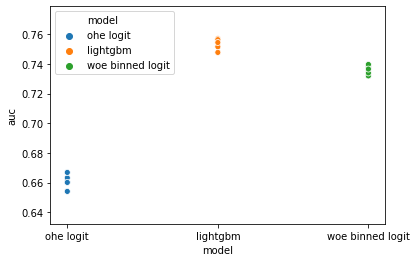

In [128]:
sns.scatterplot(data=combined_results, x="model", y="auc", hue="model")

In [ ]:
woebin_logit.fit(X, y)

In [ ]:
def plot_feature_importance(
    var_names, coefficients, n=10, output_dir=None, verbose=True
):
    """
    Find logit regression feature importance
    Args:
        var_names (series): variable names
        coefficients (series): regression coefficients
        n (integer): how many features to plot
    """
    coef_df = pd.DataFrame()
    coef_df["var_names"] = var_names
    coef_df["coef_vals"] = coefficients
    coef_df["abs_vals"] = np.abs(coef_df.coef_vals)
    coef_df = coef_df.set_index("var_names").sort_values(by="abs_vals", ascending=True)
    if verbose:
        plt.figure(figsize=(4, 8))
        ax = coef_df.tail(n).coef_vals.plot.barh()
        plt.title(f"Top {n} features - logistic regression \n")
        plt.show()
    return coef_df.reset_index()

In [ ]:
var_importance = plot_feature_importance(
    X.columns, woebin_logit["log_reg_classifier"].coef_[0], n=5
)

In [ ]:
top_5 = var_importance.tail(5).var_names[::-1]

In [ ]:
weight_of_evidence.plot_bins(X[top_5], y, woebin_logit["tree_bin"].splits_)

In [ ]:
first = X.head(1)

In [ ]:
first.T

In [ ]:
first_encoded = woebin_logit["standard_scale"].transform(
    woebin_logit["woe_scale"].transform(woebin_logit["tree_bin"].transform(first))
)

In [ ]:
first_encoded

In [ ]:
woebin_logit["log_reg_classifier"].predict_proba(first_encoded)

In [ ]:
y.mean()

In [ ]:
first_importance = first_encoded * woebin_logit["log_reg_classifier"].coef_

In [ ]:
importance_cols = plot_feature_importance(X.columns, first_importance[0], n=10)